# <span style="color:#00BDFF">using functions for calibration transfer </span>

## here we will use the different transfer methods to compare how the coefficients of the baseline model change after transfer

In [1]:
# --------------------------------------------------------------------------

# ----------------- caltransfer protocol with transfer samples

# -------------------------------------------------------------------------


# ¡¡¡ --- !!! # ---> modules and data cases

# --- system modules

import sys
import datetime
import os


# --- data handling modules

import numpy as np
import pandas as pd

# --- pls model building

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression




# --- visualization modules

import matplotlib.pyplot as plt
import pandas as pd

# --- my modules

import pycaltransfer.caltransfer as caltransfer



# input data

In [2]:


data_url = "https://gitlab.com/vfonsecad/chemometrics_data/-/raw/main/data/nir_pharmaceutical_tablets/nir_shootout_2002_all.csv"
data_pd_raw = pd.read_csv(data_url, sep = ";", index_col = 0)
data_pd_all = data_pd_raw.dropna(axis=0, how='any') # dropping na for this analysis
print(data_pd_all)
print(data_pd_all.columns)




           sample_id         type    instrument    weight     hardness  \
0       sample_cal_0  calibration  instrument_1  378.019989  20.900000   
1       sample_cal_1  calibration  instrument_1  377.940002  18.100000   
2       sample_cal_2  calibration  instrument_1  377.290009  19.200001   
3       sample_cal_3  calibration  instrument_1  380.929993  17.600000   
4       sample_cal_4  calibration  instrument_1  382.549988  20.200001   
..               ...          ...           ...         ...        ...   
455  sample_test_455         test  instrument_2  380.070007  18.299999   
456  sample_test_456         test  instrument_2  371.989990  17.900000   
457  sample_test_457         test  instrument_2  373.670013  20.000000   
458  sample_test_458         test  instrument_2  377.940002  18.500000   
459  sample_test_459         test  instrument_2  380.410004  16.799999   

       assay            1         2         3         4  ...       641  \
0    200.100006  3.222009  3.220346  

In [3]:
# drop samples according to ref paper https://doi.org/10.1016/j.saa.2019.117653

cal_samples = ["sample_cal_{}".format(ii-1) for ii in [19, 122, 126, 127]]
test_samples = ["sample_test_{}".format(ii-1) for ii in [11, 145, 267, 295, 294, 342, 313, 341, 343]]

data_pd = data_pd_all[~data_pd_all["sample_id"].isin(cal_samples + test_samples)]


# get data for calibration and for transfer

In [4]:
y_name = 'assay   ' # name of y variable

primary_name = "instrument_1"
secondary_name = "instrument_2"

n_transfer = 15

In [5]:
x_primary_cal_raw = np.array(data_pd[(data_pd["instrument"]==primary_name) & (data_pd["type"]=="calibration")].iloc[:,6:])
y_primary_cal = np.array(data_pd[(data_pd["instrument"]==primary_name) & (data_pd["type"]=="calibration")].loc[:,y_name])

x_secondary_test_raw = np.array(data_pd[(data_pd["instrument"]==secondary_name) & (data_pd["type"]=="test")].iloc[:,6:])
y_secondary_test = np.array(data_pd[(data_pd["instrument"]==secondary_name) & (data_pd["type"]=="test")].loc[:,y_name])



In [6]:
# choose from calibration observations for transfer with kennard stone

n_cal = x_primary_cal_raw.shape[0]



transfer_samples = np.random.choice(n_cal, n_transfer, replace = False)

df_transfer_primary = data_pd[(data_pd["instrument"]==primary_name) & (data_pd["type"]=="calibration")].iloc[transfer_samples]
df_transfer_primary_sorted = df_transfer_primary.sort_values("sample_id")
df_transfer_secondary_all = data_pd[(data_pd["instrument"]==secondary_name) & (data_pd["type"]=="calibration")]
df_transfer_secondary = df_transfer_secondary_all[df_transfer_secondary_all["sample_id"].isin(df_transfer_primary_sorted["sample_id"])]
df_transfer_secondary_sorted = df_transfer_secondary.sort_values("sample_id")

print(np.all(df_transfer_primary_sorted["sample_id"] == df_transfer_secondary_sorted["sample_id"]))

x_primary_raw = np.array(df_transfer_primary_sorted.iloc[:,6:])
x_secondary_raw = np.array(df_transfer_secondary_sorted.iloc[:,6:])

y_primary = np.array(df_transfer_primary_sorted.loc[:,y_name]) # or None
y_secondary = np.array(df_transfer_secondary_sorted.loc[:,y_name]) # or None


wv_range = np.arange(600, 1900,2)

K = wv_range.shape[0]

True


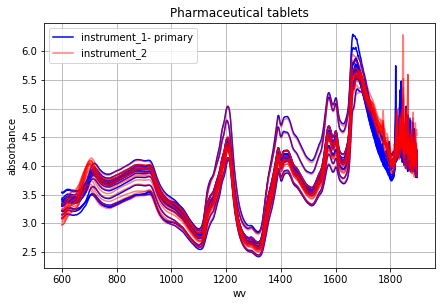

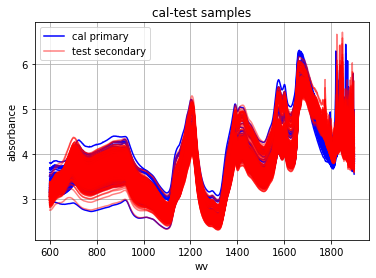

In [7]:
# visualize data
plt.subplots(figsize=(7,4.5))
plt.plot(wv_range,x_primary_raw[0], c = "blue", label = primary_name + "- primary")
plt.plot(wv_range,x_primary_raw.T, c = "blue")
plt.plot(wv_range,x_secondary_raw[0], c = "red", alpha = 0.5, label = secondary_name)
plt.plot(wv_range,x_secondary_raw.T, c = "red", alpha = 0.5)
plt.xlabel("wv")
plt.ylabel("absorbance")
plt.title("Pharmaceutical tablets")
plt.legend(loc = 0)
plt.grid()
plt.show()


plt.plot(wv_range,x_primary_cal_raw[0], c = "blue", label = "cal primary")
plt.plot(wv_range,x_primary_cal_raw.T, c = "blue")
plt.plot(wv_range,x_secondary_test_raw[0], c = "red", alpha = 0.5, label = "test secondary")
plt.plot(wv_range,x_secondary_test_raw.T, c = "red", alpha = 0.5)
plt.xlabel("wv")
plt.ylabel("absorbance")
plt.title("cal-test samples")
plt.legend(loc = 0)
plt.grid()
plt.show()

# build reference model

In [8]:
# B contains the regression vector of the model

mod_lv = 5

x_primary_cal = x_primary_cal_raw.copy()

x_mean = np.mean(x_primary_cal,axis=0)


# plsr using sklearn

my_pls = PLSRegression(n_components = mod_lv,scale=False)
my_pls.fit(x_primary_cal, y_primary_cal)
T_scores = (x_primary_cal-x_mean).dot(my_pls.x_rotations_)
my_pls_ls = LinearRegression()
my_pls_ls.fit(T_scores,y_primary_cal) # output values need to be 1D always here


# deliver parameters for plsr

R = my_pls.x_rotations_ #loadings to calculate scores
q = my_pls_ls.coef_
y_mean = my_pls_ls.intercept_ 
B = my_pls.coef_ # must be the same as Rq. final regression vector
beta = y_mean - (x_mean.dot(B))



# transfer with DS

In [9]:
x_primary = x_primary_raw.copy()
x_secondary = x_secondary_raw.copy()


In [10]:
F, a = caltransfer.ds_pc_transfer_fit(x_primary, x_secondary, max_ncp = 5)
B_ds = F.dot(B)

# transfer with PDS

In [11]:
F,b = caltransfer.pds_pls_transfer_fit(x_primary, x_secondary, max_ncp = 1, ww = 3)
B_pds = F.dot(B)

# transfer with EPO

In [12]:
E,b = caltransfer.epo_fit(x_primary, x_secondary,epo_ncp=1)
B_epo = F.dot(B)



x_mean_epo = np.mean(x_primary_cal.dot(E), axis = 0)
x_mean_epo.shape = (1, x_mean_epo.shape[0])

# plsr using sklearn after EPO

my_pls_epo = PLSRegression(n_components = mod_lv,scale=False)
my_pls_epo.fit(x_primary_cal.dot(E), y_primary_cal)

# final parameters

y_mean = y_primary_cal.mean(axis=0)
B_epo = E.dot(my_pls_epo.coef_) # must be the same as Rq. final regression vector
beta_epo = y_mean - (x_mean_epo.dot(B_epo))



# transfer with Joint Y PLS

In [13]:
tprimary = (x_primary-x_mean).dot(my_pls.x_rotations_)
tsecondary = (x_secondary-x_mean).dot(my_pls.x_rotations_)

Q,b0 = caltransfer.jointypls_regression(tprimary, tsecondary, y_primary, y_secondary)


B_jointypls = np.dot(R,Q)   
beta_jointypls = np.asarray(b0 - (x_mean).dot(B_jointypls))
beta_jointypls.shape = beta.shape



# transfer with diPLS

In [14]:

my_lambda = 0.0001

X_dipls = x_primary_cal.copy()
y_dipls = y_primary_cal.copy()
Xs_dipls = x_primary.copy()
Xt_dipls = x_secondary.copy()

model_dipls = caltransfer.dipals(X_dipls,y_dipls,Xs_dipls,Xt_dipls,A = mod_lv, l = my_lambda, center_mode = "target")

B_dipls = model_dipls[0]
beta_dipls = model_dipls[1] 



# transfer with slope and bias correction

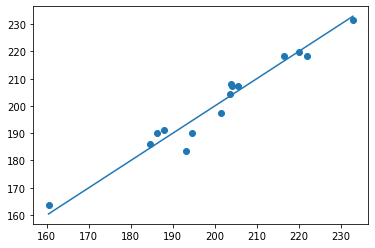

In [15]:
y_secondary_pred = x_secondary.dot(B) + beta

slope, bias = caltransfer.slope_bias_correction(y_secondary, y_secondary_pred)

B_sbc = B.dot(slope)
beta_sbc = beta.dot(slope) + bias

plt.scatter(y_secondary, x_secondary.dot(B_sbc) + beta_sbc)
plt.plot([np.amin(y_secondary), np.amax(y_secondary)],[np.amin(y_secondary), np.amax(y_secondary)])
plt.show()

# all regression vectors

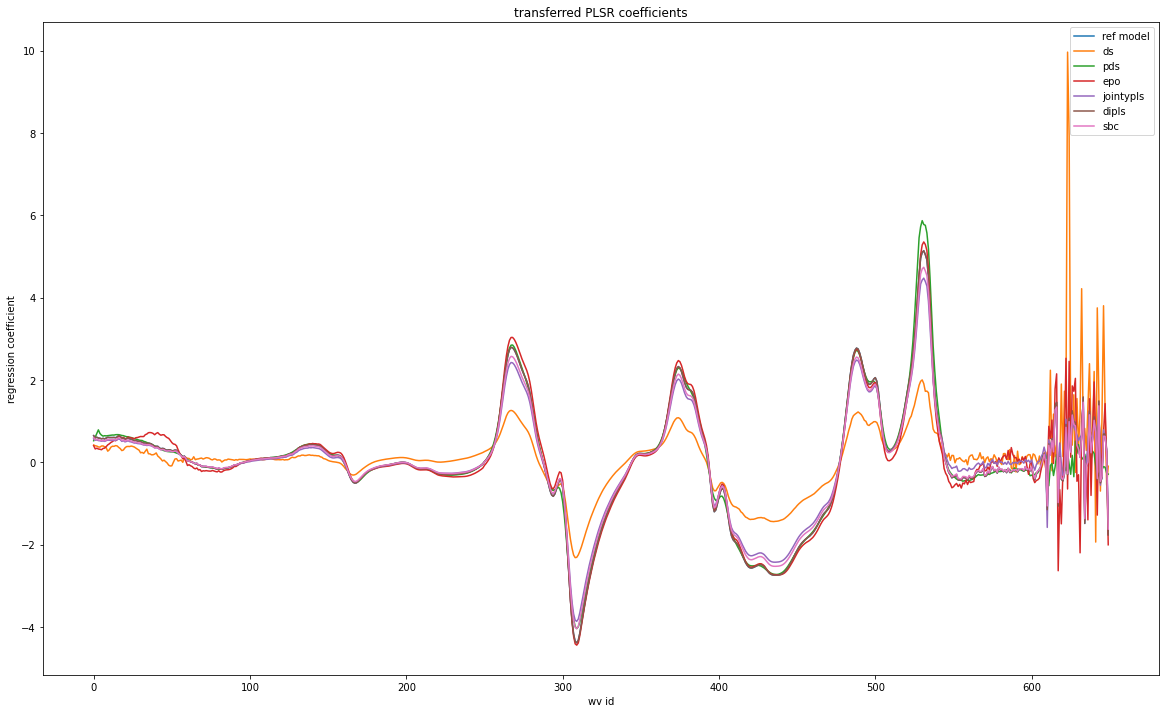

In [16]:


fig, ax = plt.subplots(figsize = (20,12))

ax.plot(B, label = "ref model")
ax.plot(B_ds, label = "ds")
ax.plot(B_pds, label = "pds")
ax.plot(B_epo, label = "epo")
ax.plot(B_jointypls, label = "jointypls")
ax.plot(B_dipls, label = "dipls")
ax.plot(B_sbc, label = "sbc")
ax.set_xlabel("wv id")
ax.set_ylabel("regression coefficient")
ax.set_title("transferred PLSR coefficients")
ax.legend()
plt.show()




